# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Regression Modeling to Forecast Bike Sharing Usage



**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Chris Tanner

<hr style="height:2pt">

In [6]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Polynomial Regression, Ridge and Lasso Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore ridge and lasso regression to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).



### Use only the libraries below:

In [7]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix

### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `casual` (number of rides that hour made by casual riders, not registered in the system)
- `registered` (number of rides that hour made by registered riders)

<div class="exercise"> <b> Question 1 [6pts]: Data Read-In and Processing </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df_raw`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**Hint:** http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

**1.1 Load the dataset from the csv file...**

In [8]:
bikes_df_raw = pd.read_csv('data/BSS_hour_raw.csv')

In [9]:
bikes_df_raw.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


In [10]:
bikes_df_raw.shape

(17379, 13)

In [11]:
bikes_df_raw.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


In [12]:
bikes_df_raw.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

The range for temp is a bit suspect because the minimum value is 0.02 (with maximum value at 1) and this variable ought to represent the normalized temperature in Celsius. For normalized values (such as temp), we expect the minimum value to be 0. It is also suspect that the windspeed max is 0.85 even though this variable should also be normalized which would make the maximum 1. Although the ranges for the number of rides per hour by causal and registered users are quite large at 0 to 367 and 0 to 886, respectively, these ranges are plausible because the registered users still have a much larger maximum (886) and average (154) number of rides per hour compared to causal users (maximum of 367 and average of 36 rides). It is noteworthy that the mean is not in the center of the range for the variables causal and registered. It is possible (but not guarenteed) that there are high outliers with large positive values for causal and registered influencing the range of these variables. The datatypes as shown above are all reasonable for the variables (dteday is an object because it shows a date as YYYY-MM-DD, which may not be useful for analysis but it does confirm that the data are provided in a way that is consistent with how they are described; temp, atemp, hum, and windspeed are all normalized so they ought to be floats as shown).

It is also noteworthy that workingday is provided as a variable in the dataset but is not described in the overview section of the problem. The variable dteday is not included in the "describe" table because it is an object that is not currently amenable to the .describe method for dataframes.

**1.2 Notice that the variable in column...**

In [13]:
bikes_df_raw['dteday'] = pd.to_datetime(bikes_df_raw['dteday'], format = '%Y-%m-%d')

In [14]:
bikes_df_raw.dtypes

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

In [15]:
bikes_df_raw.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


**1.3 Create three new columns in the dataframe:...**

1.3 Create three new columns in the dataframe:
year with 0 for 2011, 1 for 2012, etc.
month with 1 through 12, with 1 denoting January.
counts with the total number of bike rentals for that hour (this is the response variable for later).

In [93]:
# source: https://stackoverflow.com/questions/55776571/how-to-split-a-date-column-into-separate-day-month-year-column-in-pandas
bikes_df_raw['year'] = bikes_df_raw['dteday'].map(lambda x: x.year - 2011)
bikes_df_raw['month'] = bikes_df_raw['dteday'].map(lambda x: x.month)
bikes_df_raw['counts'] = bikes_df_raw['casual'] + bikes_df_raw['registered']

In [94]:
bikes_df_raw

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,0,1,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,0,1,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,0,1,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,0,1,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,0,1,1
5,2011-01-01,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,0,1,1
6,2011-01-01,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,0,1,2
7,2011-01-01,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,0,1,3
8,2011-01-01,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,0,1,8
9,2011-01-01,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,0,1,14


In [143]:
#bikes_df_raw3 = bikes_df_raw.groupby(bikes_df_raw.hour).transform('count')
#display(bikes_df_raw3.head())
#display(bikes_df_raw3.shape)
#bikes_df_raw['counts'] = bikes_df_raw3['dteday'] # could choose any column from the groupby table
# counts column here shows the number of rides made during hour 3 (or whatever hour it should be given the entry) across all days (so grouping all observations, which occur across different days, by hour then getting counts for each hour and putting that number in the row while maintaining total number of observations in original dataset) 

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month
0,726,726,726,726,726,726,726,726,726,726,726,726,726,726,726
1,724,724,724,724,724,724,724,724,724,724,724,724,724,724,724
2,715,715,715,715,715,715,715,715,715,715,715,715,715,715,715
3,697,697,697,697,697,697,697,697,697,697,697,697,697,697,697
4,697,697,697,697,697,697,697,697,697,697,697,697,697,697,697


(17379, 15)

In [144]:
#display(bikes_df_raw.head())
#display(bikes_df_raw.shape)

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,2011,1,726
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,2011,1,724
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,2011,1,715
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,2011,1,697
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,2011,1,697


(17379, 16)

---

<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question we begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**Hint:** helpful to use panda's `.groupby()` command

**2.2** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

**2.3** Convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding** and call this new dataframe `bikes_df`.

**2.4** Split the updated `bikes_df` dataset into a 50-50 train-test split (call them `bikes_train` and `bikes_test`, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set.  Use `random_state=90`, a test set size of .5, and stratify on month.  Remember to specify the data's index column as you read it in.

**2.5** Although we asked you to create your train and test set, for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). 

**2.6** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among the list of predictors listed below in the training dataset. Note and comment on any strongly related variables. [This may take a few minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

`cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']`

**2.7** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.8** Use the one-hot-encoded `weather` related variables to show how each weather category affects the relationships in question 2.7.  Remember you should have four plots, one for each weather type (Cloudy, Storm, Snow, and Clear), even though there are only three columns related to weather after one-hot-encoding. What do you observe?

### Answers

**2.1 Make a new dataframe...**

In [18]:
def new_columns(df_by_hour):
    dteday_list = 12
    month_list = bikes_df_raw.groupby(bikes_df_raw.dteday).mean().month #added in month column
    weather_list = bikes_df_raw.groupby(bikes_df_raw.dteday).max()['weather']
    temp_list = bikes_df_raw.groupby(bikes_df_raw.dteday).mean()['temp']
    atemp_list = bikes_df_raw.groupby(bikes_df_raw.dteday).mean()['atemp']
    windspeed_list = bikes_df_raw.groupby(bikes_df_raw.dteday).mean()['windspeed']
    hum_list = bikes_df_raw.groupby(bikes_df_raw.dteday).mean()['hum']
    weekday_list = bikes_df_raw.groupby(bikes_df_raw.dteday).mean()['weekday']
    season_list = bikes_df_raw.groupby(bikes_df_raw.dteday).mean()['season']
    casual_list = bikes_df_raw.groupby(bikes_df_raw.dteday).sum()['casual']
    registered_list = bikes_df_raw.groupby(bikes_df_raw.dteday).sum()['registered']
    counts_list = casual_list + registered_list
    mydata = {'dteday': dteday_list, 'month': month_list, 'weekday': weekday_list, 'weather': weather_list, 'season': season_list, 'temp': temp_list, 'atemp': atemp_list, 'windspeed': windspeed_list, 'hum': hum_list, 'casual': casual_list, 'registered': registered_list, 'counts': counts_list}
    bikes_by_day_template = pd.DataFrame(mydata)
    return bikes_by_day_template

In [19]:
bikes_by_day = new_columns(bikes_df_raw)
display(bikes_by_day.head())
display(bikes_by_day.shape)

,dteday,month,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
dteday,,,,,,,,,,,,
2011-01-01,12,1.0,6.0,3,1.0,0.344167,0.363625,0.160446,0.805833,331,654,985
2011-01-02,12,1.0,0.0,3,1.0,0.363478,0.353739,0.248539,0.696087,131,670,801
2011-01-03,12,1.0,1.0,1,1.0,0.196364,0.189405,0.248309,0.437273,120,1229,1349
2011-01-04,12,1.0,2.0,2,1.0,0.200000,0.212122,0.160296,0.590435,108,1454,1562
2011-01-05,12,1.0,3.0,1,1.0,0.226957,0.229270,0.186900,0.436957,82,1518,1600


(731, 12)

In [97]:
bikes_by_day.index[0] # do we need to add a specific hours col?

Timestamp('2011-01-01 00:00:00')

In [20]:
# 7 things (each is one day of the week) on x axis but each thing has a distribution because there are a lot of mondays, etc

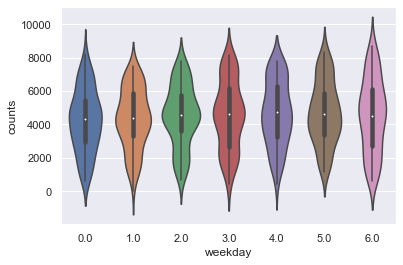

In [21]:
import seaborn as sns
sns.set()
ax = sns.violinplot(x="weekday", y="counts", data=bikes_by_day)

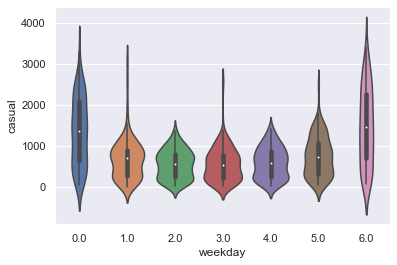

In [22]:
ax = sns.violinplot(x="weekday", y="casual", data=bikes_by_day)

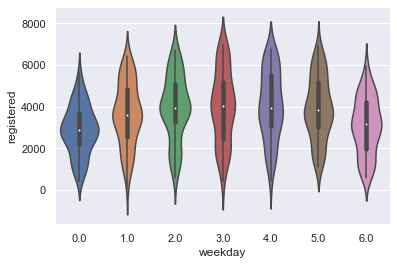

In [23]:
ax = sns.violinplot(x="weekday", y="registered", data=bikes_by_day)

In [24]:
#make pairwise violin where the casual and registered are adjcaent to each other
#may want to make boxplots instead because import does not include seaborn

**2.2 Use `bikes_by_day` to visualize how the distribution...**

Text(0, 0.5, 'counts of bikes per day')

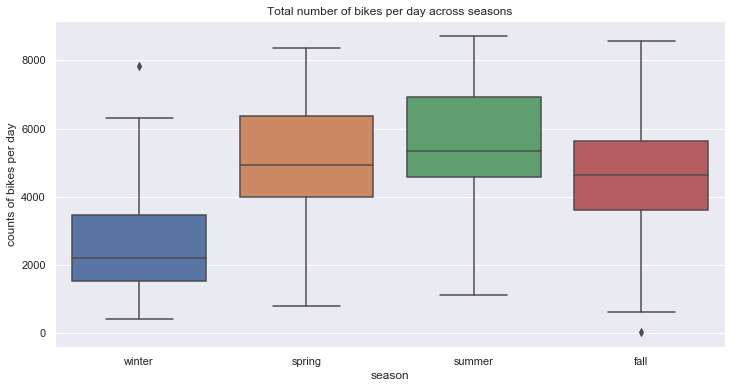

In [123]:
# your code here   USE PYPLOT BOX PLOT???????? 
fig, ax = plt.subplots(figsize=(12,6));
sns.boxplot(x="season", y="counts", data=bikes_by_day);
ax.set_title('Total number of bikes per day across seasons')
ax.set_xticklabels(['winter', 'spring', 'summer', 'fall'])
#ax.set_xlabel(['winter', 'spring', 'summer', 'fall']) #1 = winter, 2 = spring, 3 = summer, 4 = fall
ax.set_ylabel('counts of bikes per day')
#fig.title('Distribution of counts across seasons');

Text(0.5, 1.0, 'Total number of bikes per day across seasons')

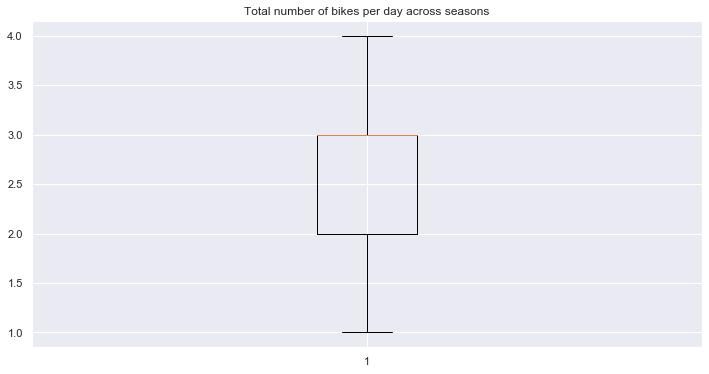

In [130]:
# your code here   
fig, ax = plt.subplots(figsize=(12,6));
data = bikes_by_day.loc[:, 'season']
ax.boxplot(data);
ax.set_title('Total number of bikes per day across seasons')
#ax.set_xticklabels(['winter', 'spring', 'summer', 'fall'])
#ax.set_xlabel(['winter', 'spring', 'summer', 'fall']) #1 = winter, 2 = spring, 3 = summer, 4 = fall
#ax.set_ylabel('counts of bikes per day')
#fig.title('Distribution of counts across seasons');

In [139]:
#data = bikes_by_day.loc[:, 'season'==1]
#data


In [114]:
# describe outliers
index_max = bikes_by_day[bikes_by_day.season == 1]['counts'].idxmax()

In [116]:
bikes_by_day.loc[index_max, :] # st patty's day; obama was having a celebratory event in DC that day which may have drew crowds
#https://obamawhitehouse.archives.gov/blog/2012/03/17/president-obama-dubliner-st-patricks-day
# parades may have roads closed so people bike

dteday          12.000000
month            3.000000
weekday          6.000000
weather          2.000000
season           1.000000
temp             0.514167
atemp            0.505046
windspeed        0.110704
hum              0.755833
casual        3155.000000
registered    4681.000000
counts        7836.000000
Name: 2012-03-17 00:00:00, dtype: float64

In [118]:
index_max_fall = bikes_by_day[bikes_by_day.season == 4]['counts'].idxmin()
bikes_by_day.loc[index_max_fall, :] #low outlier in the fall had thunderstorm weather Hurricane sandy passing through DC
#https://theweek.com/articles/470962/10-things-need-know-today-october-29-2012

dteday        12.0000
month         10.0000
weekday        1.0000
weather        3.0000
season         4.0000
temp           0.4400
atemp          0.4394
windspeed      0.3582
hum            0.8800
casual         2.0000
registered    20.0000
counts        22.0000
Name: 2012-10-29 00:00:00, dtype: float64

Use bikes_by_day to visualize how the distribution of total number of rides per day (casual and registered riders combined) varies with the season. Do you see any outliers? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help).

##DID I USE THE CORRECT PYPLOT??? to make boxplots

**Answer** There are two outliers in the total number of bikes per day with respect to seasons. For one day in the winter, there were 8000 bikes per checked out, which is a high outlier. For one day in the fall, there were 0 bikes per checked out, which is a low outlier. !!!!!St Patty's parade?? 

**2.3 Convert the categorical attributes...**

In [119]:
bikes_df.head()

,dteday,temp,atemp,windspeed,hum,casual,registered,counts,season_2.0,season_3.0,...,month_12.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,weather_2,weather_3,weather_4
dteday,,,,,,,,,,,,,,,,,,,,,
2011-01-01,12,0.344167,0.363625,0.160446,0.805833,331,654,985,0,0,...,0,0,0,0,0,0,1,0,1,0
2011-01-02,12,0.363478,0.353739,0.248539,0.696087,131,670,801,0,0,...,0,0,0,0,0,0,0,0,1,0
2011-01-03,12,0.196364,0.189405,0.248309,0.437273,120,1229,1349,0,0,...,0,1,0,0,0,0,0,0,0,0
2011-01-04,12,0.200000,0.212122,0.160296,0.590435,108,1454,1562,0,0,...,0,0,1,0,0,0,0,1,0,0
2011-01-05,12,0.226957,0.229270,0.186900,0.436957,82,1518,1600,0,0,...,0,0,0,1,0,0,0,0,0,0


In [26]:
# your code here

# no month var in bikes_by_day??

bikes_df = pd.get_dummies(bikes_by_day, columns=['season', 'month', 'weekday', 'weather'], drop_first=True)
bikes_df.columns # should we rename the col names????????

Index(['dteday', 'temp', 'atemp', 'windspeed', 'hum', 'casual', 'registered',
       'counts', 'season_2.0', 'season_3.0', 'season_4.0', 'month_2.0',
       'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0',
       'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0',
       'weekday_1.0', 'weekday_2.0', 'weekday_3.0', 'weekday_4.0',
       'weekday_5.0', 'weekday_6.0', 'weather_2', 'weather_3', 'weather_4'],
      dtype='object')

**2.4 Split the updated `bikes_df` dataset into a 50-50 train-test split...** 

In [27]:
#months_list = ['month_2.0',
#       'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0',
#       'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0']

In [28]:
#bikes_train, bikes_test = train_test_split(bikes_df, train_size=0.5, stratify = bikes_df.loc[:, months_list], random_state=90)

In [132]:
bikes_df['month_stratify'] = bikes_by_day['month']  #method shown on ed. keep 1 column for original month data, not dummies

In [136]:
bikes_df.head()

,dteday,temp,atemp,windspeed,hum,casual,registered,counts,season_2.0,season_3.0,...,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,weather_2,weather_3,weather_4,month_stratify
dteday,,,,,,,,,,,,,,,,,,,,,
2011-01-01,12,0.344167,0.363625,0.160446,0.805833,331,654,985,0,0,...,0,0,0,0,0,1,0,1,0,1.0
2011-01-02,12,0.363478,0.353739,0.248539,0.696087,131,670,801,0,0,...,0,0,0,0,0,0,0,1,0,1.0
2011-01-03,12,0.196364,0.189405,0.248309,0.437273,120,1229,1349,0,0,...,1,0,0,0,0,0,0,0,0,1.0
2011-01-04,12,0.200000,0.212122,0.160296,0.590435,108,1454,1562,0,0,...,0,1,0,0,0,0,1,0,0,1.0
2011-01-05,12,0.226957,0.229270,0.186900,0.436957,82,1518,1600,0,0,...,0,0,1,0,0,0,0,0,0,1.0


In [135]:
bikes_train, bikes_test = train_test_split(bikes_df, train_size=0.5, stratify = bikes_df['month_stratify'], random_state=90)

**2.5 Although we asked you to create your train and test set...**

In [137]:
# your code here
BSS_train = pd.read_csv('data/BSS_train.csv')
BSS_test = pd.read_csv('data/BSS_test.csv')

In [138]:
BSS_train = BSS_train.drop(columns = 'dteday')
BSS_train.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,registered,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,21,0,1,1,0.24,0.2273,0.60,0.2537,12,51,...,1,0,0,0,1,0,0,1,0,0
1,17,0,0,1,0.62,0.5758,0.83,0.2537,47,432,...,0,0,0,0,1,0,0,0,1,0
2,9,0,1,1,0.76,0.7273,0.66,0.1642,54,299,...,0,0,0,0,1,0,0,0,0,0
3,17,0,1,0,0.62,0.6061,0.22,0.2985,185,226,...,0,0,0,0,0,0,0,0,0,0
4,8,0,1,0,0.18,0.1970,0.40,0.1343,9,61,...,0,0,0,0,0,0,0,0,0,0


In [31]:
BSS_test = BSS_test.drop(columns = 'dteday')
BSS_test.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,registered,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,5,0,1,0,0.26,0.2273,0.48,0.2985,0,2,...,1,0,0,0,0,0,0,1,0,0
1,19,0,1,0,0.36,0.3485,0.71,0.1343,29,110,...,0,0,0,0,0,0,1,0,1,0
2,12,0,1,1,0.36,0.3182,0.53,0.4478,13,213,...,1,0,1,0,0,0,0,1,0,0
3,0,0,1,1,0.28,0.3030,0.65,0.0896,4,39,...,0,0,0,0,0,1,0,1,0,0
4,1,0,1,0,0.60,0.5455,0.88,0.1642,31,99,...,0,0,0,0,0,0,0,1,0,0


**2.6 Use pandas' `scatter_matrix` command to visualize...**

In [33]:
# your code here

cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']

BSS_train_select_cols = pd.DataFrame(BSS_train[cor_columns])

In [34]:
BSS_train_select_cols.head()

,hour,holiday,temp,atemp,workingday,hum,windspeed,counts,casual,registered,fall,summer,spring,Snow,Storm,Cloudy
0,21,0,0.24,0.2273,1,0.60,0.2537,63,12,51,0,0,0,0,0,1
1,17,0,0.62,0.5758,1,0.83,0.2537,479,47,432,1,0,0,1,0,0
2,9,0,0.76,0.7273,1,0.66,0.1642,353,54,299,0,1,0,0,0,0
3,17,0,0.62,0.6061,0,0.22,0.2985,411,185,226,0,0,1,0,0,0
4,8,0,0.18,0.1970,0,0.40,0.1343,70,9,61,0,0,0,0,0,0


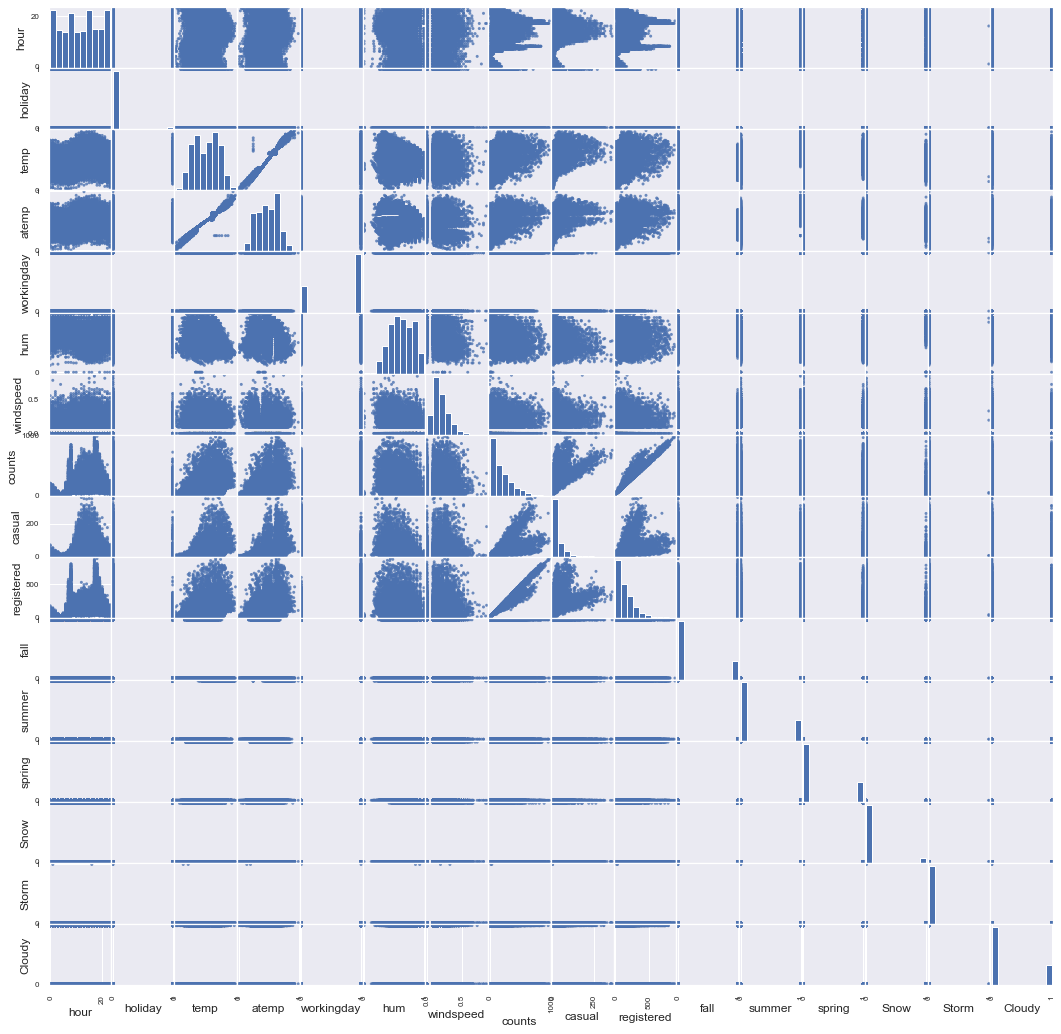

In [36]:
scatter_matrix(BSS_train_select_cols, alpha=0.8, figsize=(18, 18));  #how to get layout looking better??????

**2.7 Make a plot showing the _average_ number of casual and registered riders...**

Text(0, 0.5, 'average number of casual and registered riders')

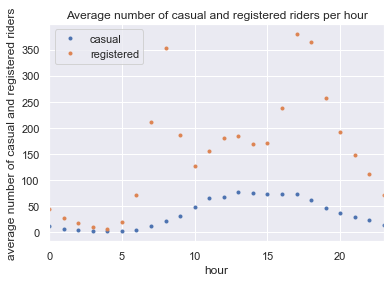

In [152]:
# your code here
BSS_train_to_plot = BSS_train.groupby('hour').agg({'casual': np.mean, 'registered': np.mean})  #may exchange 'counts' for 'casual' if want to show average for casual and registered separately not showing averaged 
ax = BSS_train_to_plot.plot(marker = '.', linestyle = " ", title = 'Average number of casual and registered riders per hour')
ax.set_ylabel('average number of casual and registered riders')

In [ ]:
### is it the average of causal AND registered together so are we making 1 plot or 2 (the latter would mean you 
#find the average checkout counts per hour across multiple days for causal users then do the same for registered users)

###### 

The number of riders per hour fluctuates across hours. From midnight to 5 am, there are relatively few average riders and by 6am the number of riders increases, rising until 8am where it peaks around 374 riders. Then the number of riders decreases until around 10am when it starts generally rising moderately until 5pm where the maximum number of riders per hour (453 riders) is reached. Then the average number of riders decreases steadily through midnight where it is below 100 riders per hour. These trends are expected given daily work commutes. Many people would use a bike on their way into work at 8am and would similarly use a bike on their way home from work around 5pm.

**2.8 Use the weather related variables to show how each weather...** 

Text(0, 0.5, 'average number of casual and registered riders for clear weather')

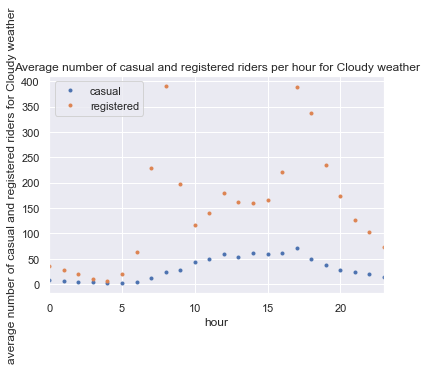

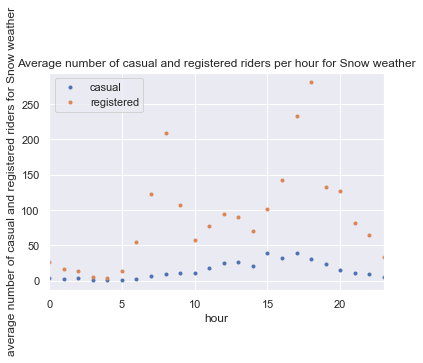

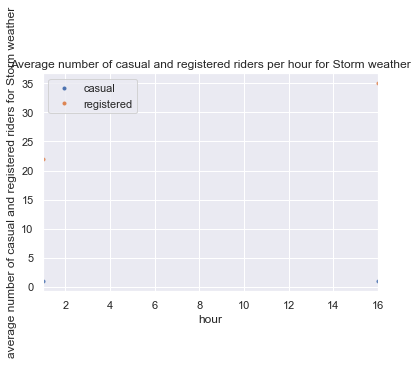

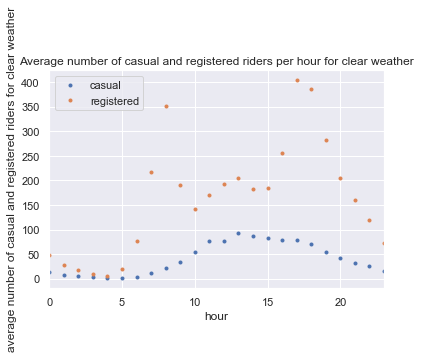

In [151]:
# your code here REALLY NOT SURE WHAT TO DO HERE?? BOX PLOTS??
for i in ['Cloudy', 'Snow', 'Storm']:
    BSS_train_to_plot = BSS_train[BSS_train[i] == 1].groupby('hour').agg({'casual': np.mean, 'registered': np.mean})
    ax = BSS_train_to_plot.plot(marker = '.', linestyle = " ", title = 'Average number of casual and registered riders per hour for {} weather'.format(i))
    ax.set_ylabel('average number of casual and registered riders for {} weather'.format(i))

BSS_train_to_plot = BSS_train[BSS_train['Cloudy'] + BSS_train['Snow'] + BSS_train['Storm'] == 0].groupby('hour').agg({'casual': np.mean, 'registered': np.mean})
ax = BSS_train_to_plot.plot(marker = '.', linestyle = " ", title = 'Average number of casual and registered riders per hour for clear weather')
ax.set_ylabel('average number of casual and registered riders for clear weather')

In [153]:
BSS_train.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,registered,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,21,0,1,1,0.24,0.2273,0.60,0.2537,12,51,...,1,0,0,0,1,0,0,1,0,0
1,17,0,0,1,0.62,0.5758,0.83,0.2537,47,432,...,0,0,0,0,1,0,0,0,1,0
2,9,0,1,1,0.76,0.7273,0.66,0.1642,54,299,...,0,0,0,0,1,0,0,0,0,0
3,17,0,1,0,0.62,0.6061,0.22,0.2985,185,226,...,0,0,0,0,0,0,0,0,0,0
4,8,0,1,0,0.18,0.1970,0.40,0.1343,9,61,...,0,0,0,0,0,0,0,0,0,0


---

<div class='exercise'> <b> Question 3 [18pts]: Multiple Linear Regression to Predict Hourly Ridership </b> </div>


**3.1** Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was derived of and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`.

**3.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). 

**3.3** You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

**3.4** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**3.5** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from your `X_train` data from question 3.1 with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**3.6** You should have received a warning regarding the presence of _multicolinearity_ in the model in 3.1.  Create a new dataset `X_train_drop` by dropping the following predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall` and fit a multiple linear regression model to the variables the remain.  Are the estimates more sensible in this model?  And explain in your own words why multicolinearity can lead to erroneous coefficient values.



### Answers

**3.1 Use statsmodels to fit a multiple linear regression model...**

In [40]:
BSS_test.columns

Index(['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'counts', 'spring', 'summer',
       'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy',
       'Snow', 'Storm'],
      dtype='object')

In [67]:
# your code here  
#what dataset should I be using???
predictor_cols = ['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed',  'spring', 'summer',
       'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy',
       'Snow', 'Storm'] # what are the usable predictors? should hour be used in this list or not?  just removed: 'casual', 'registered', 'counts',

X_train = BSS_train[predictor_cols] 
X_test = BSS_test[predictor_cols] 

model = sm.OLS(BSS_train['counts'], 
                 sm.add_constant(X_train)).fit()
display(model.summary())

print("Training R^2:", r2_score(BSS_train['counts'], model.predict(sm.add_constant(X_train))))
print("Testing R^2:", r2_score(BSS_test['counts'], model.predict(sm.add_constant(X_test))))

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     201.9
Date:                Sun, 06 Oct 2019   Prob (F-statistic):               0.00
Time:                        11:37:49   Log-Likelihood:                -55215.
No. Observations:                8689   AIC:                         1.105e+05
Df Residuals:                    8658   BIC:                         1.107e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.4075     10.908     -2.788      0.005     -51.789      -9.026
hour           7.2092      0.233     30.975      0.000       6.753       7.665
holiday      -19.1510      8.369     -2.288      0.022     -35.556      -2.746
year          78.1211      3.020     25.864      0.000      72.200      84.042
workingday    10.9484      3.512      3.118      0.002       4.065      17.832
temp         273.6625     61.680      4.437      0.000     152.755     394.570
atemp        162.5353     64.909      2.504      0.012      35.298     289.773
hum         -202.0080      9.927    -20.349      0.000    -221.468    -182.548
windspeed     19.3827     13.595      1.426      0.154      -7.268      46.033
spring        50.0754      9.528      5.256      0.000      31.398      68.753
summer        22.6879     11.138      2.037      0.042       0.855      44.521
fall          70.9474      9.448      7.509      0.000      52.426      89.469
Feb          -10.7198      7.590     -1.412      0.158     -25.598       4.158
Mar          -11.2938      8.385     -1.347      0.178     -27.731       5.143
Apr          -44.8326     12.635     -3.548      0.000     -69.600     -20.065
May          -50.1605     13.493     -3.718      0.000     -76.609     -23.712
Jun          -72.2042     13.700     -5.271      0.000     -99.058     -45.350
Jul          -90.8965     15.387     -5.907      0.000    -121.058     -60.735
Aug          -58.3246     15.061     -3.873      0.000     -87.847     -28.802
Sept         -16.1686     13.432     -1.204      0.229     -42.499      10.162
Oct          -15.8838     12.484     -1.272      0.203     -40.356       8.588
Nov          -32.7232     12.049     -2.716      0.007     -56.342      -9.104
Dec          -19.2088      9.560     -2.009      0.045     -37.949      -0.469
Mon           -3.3336      3.756     -0.888      0.375     -10.697       4.029
Tue           -0.0074      4.105     -0.002      0.999      -8.055       8.040
Wed           -2.2059      4.082     -0.540      0.589     -10.207       5.795
Thu           -5.5698      4.013     -1.388      0.165     -13.436       2.297
Fri            2.9140      4.015      0.726      0.468      -4.956      10.784
Sat           12.7461      5.587      2.281      0.023       1.793      23.699
Cloudy         6.9163      3.676      1.882      0.060      -0.289      14.122
Snow         -26.8155      6.094     -4.401      0.000     -38.760     -14.871
Storm         48.2045     98.839      0.488      0.626    -145.543     241.952
==============================================================================
Omnibus:                     1691.839   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3250.657
Skew:                           1.191   Prob(JB):                         0.00
Ku

Training R^2 (using metrics): 0.4115699822629325
Testing R^2 (using metrics): 0.40072109229413466


//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


**3.2 Examine the estimated coefficients and report...**

In [42]:
# your code here

#READ OUT FROM SUMMARY DISPLAY ONCE DECIDE ON CORRECT PREDICTORS

#July coefficient may be very large magnitude because it has colinearity with another so it is driven up.

**3.3 You should see some strange estimates for the predictors representing months...** 

The estimate (95% confidence interval) for the effect of July on counts (OF WHAT? BE PRECISE - AVG OR TOTAL???) is -90.8965 (-121.058 to -60.735). This indicates that being in the month of July is associated with having a decrease of approximately 90 counts on average. WHY DOES SUMMER HAVE A POSITIVE SLOPE ESTIMATE BUT THEN THE MONTHS ARE NEGATIVE? ESTIMATE AND CI ARE ALSO LARGE????

comment on the number of data in each category - ed says there are only 2 data points for storm?

**3.4 To diagnose the model, make two plots:...**

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Mean of residuals: 6.993395645322105e-15


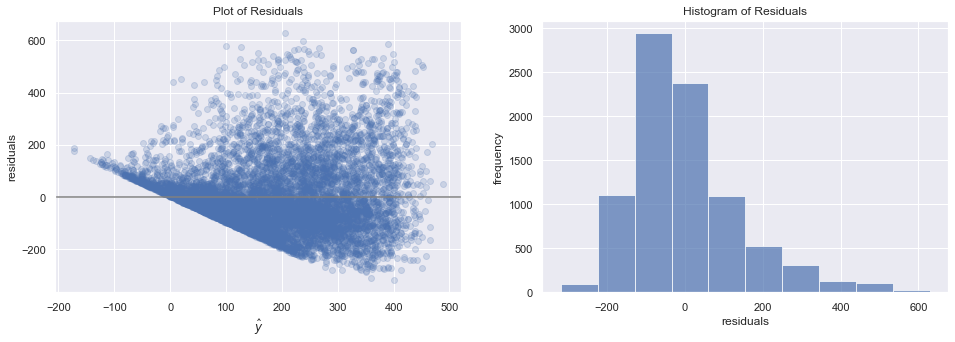

In [157]:
# your code here  Draw a horizontal line denoting the zero residual value on the Y-axis.
#What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)

predictors = sm.add_constant(BSS_train[predictor_cols])
y_hat = model.predict(predictors)
residuals = BSS_train['counts'] - y_hat

# plotting
fig, ax = plt.subplots(ncols=2, figsize=(16,5))
ax = ax.ravel()
ax[0].set_title('Plot of Residuals')
ax[0].scatter(y_hat, residuals, alpha=0.2)
ax[0].set_xlabel(r'$\hat{y}$')
ax[0].set_ylabel('residuals')
ax[0].axhline(0, color="gray")

ax[1].set_title('Histogram of Residuals')
ax[1].hist(residuals, alpha=0.7)
ax[1].set_xlabel('residuals')
ax[1].set_ylabel('frequency');

# Mean of residuals
print('Mean of residuals: {}'.format(np.mean(residuals)))

ANSWER THIS!!!!
#What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)



The histogram of residuals versus frequency shows that it is more frequent for the residual to be negative (histogram is not centered around 0) but the histogram has a longer right tail versus left tail, indicating that there are some cases where the model predicts a much smaller value than the oberved value. This tells us that the OLS assumption about normality of the error term does not hold for this data. The error term does not have constant variance, which is apparent from the scatter plot since as the predicted value increases the variability in the residual also increases (this assumption of a linear model is therefore not holding for this data). In general, the assumption that the data can be represented by a linear model is incorrect. ?????

**3.5 Perhaps we can do better via a model...**

In [44]:
# your code here temp, hour, and humidity

# have to go from X_train to make X_train_poly dataset!!!!!!!!!

BSS_train2 = BSS_train.copy()
BSS_train2['temp^2'] = BSS_train2['temp'] **2
BSS_train2['hour^2'] = BSS_train2['hour'] **2
BSS_train2['hum^2'] = BSS_train2['hum'] **2

BSS_train2.columns
predictors_2 = ['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'spring', 'summer',
       'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy',
       'Snow', 'Storm', 'temp^2', 'hour^2', 'hum^2'] # removed casual, registered, counts

In [45]:

model_5 = sm.OLS(
    BSS_train2['counts'],
    sm.add_constant(BSS_train2[predictors_2])
).fit()
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     271.3
Date:                Sun, 06 Oct 2019   Prob (F-statistic):               0.00
Time:                        11:30:42   Log-Likelihood:                -54433.
No. Observations:                8689   AIC:                         1.089e+05
Df Residuals:                    8655   BIC:                         1.092e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -193.3332     17.588    -10.992      0.000    -227.810    -158.857
hour          40.2211      0.840     47.896      0.000      38.575      41.867
holiday      -14.0310      7.656     -1.833      0.067     -29.039       0.977
year          83.2098      2.781     29.921      0.000      77.758      88.661
workingday    13.2241      3.212      4.117      0.000       6.928      19.520
temp          46.0096     78.769      0.584      0.559    -108.397     200.416
atemp        148.5309     61.182      2.428      0.015      28.599     268.463
hum           42.3171     45.426      0.932      0.352     -46.729     131.363
windspeed    -19.4101     12.531     -1.549      0.121     -43.973       5.153
spring        46.8322      8.714      5.374      0.000      29.750      63.914
summer        25.4085     10.202      2.490      0.013       5.410      45.407
fall          74.7289      8.643      8.646      0.000      57.787      91.671
Feb           -2.2754      7.037     -0.323      0.746     -16.070      11.519
Mar            9.1429      7.906      1.156      0.248      -6.355      24.641
Apr          -12.2792     11.781     -1.042      0.297     -35.373      10.814
May          -15.6791     12.489     -1.255      0.209     -40.160       8.802
Jun          -29.8762     12.639     -2.364      0.018     -54.652      -5.100
Jul          -51.5208     14.156     -3.640      0.000     -79.269     -23.773
Aug          -23.3642     13.901     -1.681      0.093     -50.613       3.884
Sept          11.0442     12.519      0.882      0.378     -13.495      35.584
Oct           -1.9320     11.682     -0.165      0.869     -24.831      20.967
Nov          -27.7996     11.221     -2.478      0.013     -49.795      -5.804
Dec          -19.1169      8.871     -2.155      0.031     -36.506      -1.728
Mon           -0.9673      3.434     -0.282      0.778      -7.699       5.764
Tue            0.9441      3.753      0.252      0.801      -6.412       8.301
Wed           -1.8581      3.731     -0.498      0.619      -9.172       5.456
Thu           -2.7283      3.669     -0.744      0.457      -9.921       4.465
Fri            3.8028      3.671      1.036      0.300      -3.393      10.999
Sat           18.1315      5.113      3.546      0.000       8.109      28.154
Cloudy        -9.5074      3.389     -2.805      0.005     -16.151      -2.864
Snow         -46.9213      5.765     -8.139      0.000     -58.222     -35.620
Storm         34.1383     90.378      0.378      0.706    -143.024     211.301
temp^2       140.6804     46.276      3.040      0.002      49.968     231.393
hour^2        -1.3881      0.034    -40.654      0.000      -1.455      -1.321
hum^2       -126.8873     36.621     -3.465      0.001    -198.673     -55.102
==============================================================================
Om

**3.6 You should have received a warning regarding the presence of _multicollinearity_...**

In [158]:
# your code here

#how to drop predictors directly from X_train
# drop workingday atemp spring summer and fall
#what dataset should I be using???
predictor_cols2 = ['hour', 'holiday', 'year', 'temp', 'hum',
       'windspeed', 'Feb', 'Mar', 'Apr', 'May',
       'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed',
       'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm'] # what are the usable predictors? should hour be used in this list or not?  just removed: 'casual', 'registered', 'counts',

X_train2 = BSS_train[predictor_cols2] 
X_test2 = BSS_test[predictor_cols2] 



model3 = sm.OLS(BSS_train2['counts'], 
                 sm.add_constant(X_train2)).fit()
display(model3.summary())

print("Training R^2 (using metrics):", r2_score(BSS_train['counts'], model3.predict(sm.add_constant(X_train2))))
print("Testing R^2 (using metrics):", r2_score(BSS_test['counts'], model3.predict(sm.add_constant(X_test2))))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     226.9
Date:                Sun, 06 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:08:58   Log-Likelihood:                -55263.
No. Observations:                8689   AIC:                         1.106e+05
Df Residuals:                    8662   BIC:                         1.108e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.2056     10.772     -2.433      0.015     -47.322      -5.089
hour           7.2218      0.234     30.871      0.000       6.763       7.680
holiday      -37.2529      9.390     -3.967      0.000     -55.659     -18.846
year          77.9687      3.035     25.691      0.000      72.020      83.918
temp         425.3856     16.922     25.137      0.000     392.214     458.557
hum         -198.2002      9.944    -19.933      0.000    -217.692    -178.709
windspeed      3.0647     13.166      0.233      0.816     -22.743      28.872
Feb          -10.3801      7.624     -1.362      0.173     -25.324       4.564
Mar            4.8473      7.834      0.619      0.536     -10.510      20.205
Apr            5.6103      8.422      0.666      0.505     -10.899      22.119
May           -2.4330      9.725     -0.250      0.802     -21.497      16.631
Jun          -35.3982     10.671     -3.317      0.001     -56.316     -14.480
Jul          -72.2768     11.583     -6.240      0.000     -94.982     -49.571
Aug          -40.9043     11.043     -3.704      0.000     -62.551     -19.258
Sept          15.9133     10.059      1.582      0.114      -3.805      35.632
Oct           54.0377      8.686      6.221      0.000      37.010      71.065
Nov           38.3870      7.796      4.924      0.000      23.106      53.668
Dec           26.2086      7.582      3.457      0.001      11.346      41.071
Mon            9.6638      5.802      1.666      0.096      -1.709      21.036
Tue           11.4788      5.705      2.012      0.044       0.295      22.663
Wed            8.5964      5.676      1.515      0.130      -2.529      19.722
Thu            5.9261      5.641      1.050      0.294      -5.132      16.984
Fri           13.5104      5.640      2.396      0.017       2.455      24.566
Sat           12.3255      5.614      2.196      0.028       1.321      23.330
Cloudy         7.0689      3.692      1.915      0.056      -0.169      14.306
Snow         -27.3958      6.112     -4.483      0.000     -39.376     -15.415
Storm         44.8939     99.348      0.452      0.651    -149.852     239.640
==============================================================================
Omnibus:                     1712.709   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3312.120
Skew:                           1.202   Prob(JB):                         0.00
Kurtosis:                       4.837   Cond. No.                         898.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Training R^2 (using metrics): 0.4050932865116824
Testing R^2 (using metrics): 0.39719478258457475


//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [169]:
BSS_train['counts'].shape

(8689,)

EXPLAIN ANS TO THESE QUESTIONS  !!!!!!!!!!!

Are the estimates more sensible in this model? And explain in your own words why multicolinearity can lead to erroneous coefficient values.


Estimates for the month coefficients are smaller because we dropped the seasons


In [47]:
X_train.columns

Index(['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May',
       'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed',
       'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm'],
      dtype='object')

---

<div class='exercise'> <b> Question 4 [20pts]: Regression Models with Polynomial and Interaction Terms </b> </div>

**4.1** Drop the variables `workingday`, `atemp`, `spring`, `summer`, `fall`, and  `dteday` from `BSS_train` (if any of them still remain).

**4.2** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**4.3** Write a code to augment your a dataset with higher-order features for `temp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `temp^2` and `hum^2` but not `temp*hum` or any other two-feature interactions. 

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**4.4** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `temp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**4.5** Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.


**4.6** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

**4.7** Discuss patterns you see in the results from 4.5. Which model would you select, and why?

### Answers

**4.1 Drop...**

In [155]:
# your code here
print('Columns present originally:', BSS_train.columns, len(BSS_train.columns))
cols_to_drop = ['workingday','atemp', 'spring', 'summer', 'fall']
BSS_train_clean = BSS_train.drop(cols_to_drop,axis=1)
print('Columns present after the drop:', BSS_train_clean.columns, len(BSS_train_clean.columns))

Columns present originally: Index(['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'counts', 'spring', 'summer',
       'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy',
       'Snow', 'Storm'],
      dtype='object') 34
Columns present after the drop: Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'casual',
       'registered', 'counts', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm'],
      dtype='object') 29


**4.2 Write a function to standardize...**

In [159]:
# your code here
def make_standardized_df(train, test, columns_to_use): #assuming test is same as validation
    #x_train = train[columns_to_use]
    #x_test = test[columns_to_use]
    #y_train = train['counts']
    #y_test = test['counts']
    #make list of standardizing parameters
    standardized_col_data_test = []
    standardized_col_data_train = []
    for i in range(len(columns_to_use)):
        col_data_train = train.loc[:, columns_to_use[i]]
        standardized_col_mean = col_data_train.mean()
        standardized_col_std = col_data_train.std()
        col_data_test = test.loc[:, columns_to_use[i]]
        standardized_col_data_test.append((col_data_test - standardized_col_mean)/(standardized_col_std))
        standardized_col_data_train.append((col_data_train - standardized_col_mean)/(standardized_col_std))
        standardized_df_train_cut = pd.DataFrame(standardized_col_data_train).transpose()
        standardized_df_test_cut = pd.DataFrame(standardized_col_data_test).transpose()
        #standardized_df_train_all = train.update(standardized_df_train_cut)
        #standardized_df_test_all = test.update(standardized_df_test_cut)
    return standardized_df_train_cut, standardized_df_test_cut

In [ ]:
#try doing it with pd.columns.difference and standardscaler???
df_new = df[df.columns.difference(['B', 'D'])]
def make_standardized_df2(train, test, columns_to_drop): #assuming test is same as validation
    df_to_standardize = pd.columns.difference(columns_to_drop)
    
    standardized_col_mean = df_to_standardize.mean() #standardscaler????
    standardized_col_std = df_to_standardize.std()
    return standardized_df_train2, standardized_df_test2



In [160]:
cols_to_test = ['temp', 'hum', 'Aug']
practice_X_train = make_standardized_df(X_train, X_test, cols_to_test)
practice_X_train_scaled = practice_X_train[0]
display(practice_X_train[0].describe())
display(practice_X_train[1].describe())
display(practice_X_train[0].head())
display(practice_X_train[1].head())

,temp,hum,Aug
count,8.689000e+03,8.689000e+03,8.689000e+03
mean,1.180187e-14,3.874411e-14,5.083209e-16
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.474050e+00,-3.251787e+00,-3.044182e-01
25%,-8.122357e-01,-7.554373e-01,-3.044182e-01
50%,1.867126e-02,-2.733539e-02,-3.044182e-01
75%,8.495782e-01,8.047811e-01,-3.044182e-01
max,2.511392e+00,1.948941e+00,3.284577e+00


,temp,hum,Aug
count,8690.000000,8690.000000,8690.000000
mean,0.006050,0.020518,0.000378
std,1.000001,1.006692,1.000563
min,-2.474050,-3.251787,-0.304418
25%,-0.812236,-0.755437,-0.304418
50%,0.018671,0.024672,-0.304418
75%,0.849578,0.856788,-0.304418
max,2.615255,1.948941,3.284577


,temp,hum,Aug
0,-1.331553,-0.131350,-0.304418
1,0.641851,1.064817,-0.304418
2,1.368895,0.180694,3.284577
3,0.641851,-2.107627,-0.304418
4,-1.643143,-1.171496,-0.304418


,temp,hum,Aug
0,-1.227689,-0.755437,-0.304418
1,-0.708372,0.440730,-0.304418
2,-0.708372,-0.495401,-0.304418
3,-1.123826,0.128686,-0.304418
4,0.537988,1.324854,-0.304418


In [161]:
practice_X_train_scaled = practice_X_train[0]

In [162]:
BSS_train.update(practice_X_train[0])
practice_X_train_scaled = BSS_train

In [163]:
practice_X_train_scaled.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,registered,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,21,0,1,1,-1.331553,0.2273,-0.131350,0.2537,12,51,...,1,0,0,0,1,0,0,1,0,0
1,17,0,0,1,0.641851,0.5758,1.064817,0.2537,47,432,...,0,0,0,0,1,0,0,0,1,0
2,9,0,1,1,1.368895,0.7273,0.180694,0.1642,54,299,...,0,0,0,0,1,0,0,0,0,0
3,17,0,1,0,0.641851,0.6061,-2.107627,0.2985,185,226,...,0,0,0,0,0,0,0,0,0,0
4,8,0,1,0,-1.643143,0.1970,-1.171496,0.1343,9,61,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#HOW DO YOU VERIFY THAT YOU HAVE CORRECTLY SCALED ALL COLUMNS

**4.3 Write code to augment your a dataset with higher-order features for...**

In [ ]:
#Encapsulate this process as a function with appropriate inputs and outputs, 
#and test your code by producing practice_X_train_poly, a training dataset with quadratic and 
#cubic features built from practice_X_train_scaled, and printing practice_X_train_poly's column names and .head()



In [164]:
# your code here

# should we include regular columsn too now????
cols_to_add_higher_order = ['temp', 'hum', 'windspeed', 'hour'] # variables to do
higher_order_list = [2, 3] # degrees to do


# code from section 4
def add_higher_order_polynomial_terms(df, cols_to_add_higher_order, higher_order_list):
    df = df.copy()
    cols = df.loc[:, cols_to_add_higher_order].columns.copy()
    for col in cols:
        for i in higher_order_list:
            df['{}^{}'.format(col, i)] = df[col]**i
    return df

In [165]:
practice_X_train_poly = add_higher_order_polynomial_terms(practice_X_train_scaled, cols_to_add_higher_order, higher_order_list)

In [166]:
practice_X_train_poly.columns

Index(['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'counts', 'spring', 'summer',
       'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy',
       'Snow', 'Storm', 'temp^2', 'temp^3', 'hum^2', 'hum^3', 'windspeed^2',
       'windspeed^3', 'hour^2', 'hour^3'],
      dtype='object')

In [167]:
practice_X_train_poly.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,registered,...,Snow,Storm,temp^2,temp^3,hum^2,hum^3,windspeed^2,windspeed^3,hour^2,hour^3
0,21,0,1,1,-1.331553,0.2273,-0.131350,0.2537,12,51,...,0,0,1.773032,-2.360885,0.017253,-0.002266,0.064364,0.016329,441,9261
1,17,0,0,1,0.641851,0.5758,1.064817,0.2537,47,432,...,1,0,0.411973,0.264426,1.133836,1.207329,0.064364,0.016329,289,4913
2,9,0,1,1,1.368895,0.7273,0.180694,0.1642,54,299,...,0,0,1.873874,2.565136,0.032650,0.005900,0.026962,0.004427,81,729
3,17,0,1,0,0.641851,0.6061,-2.107627,0.2985,185,226,...,0,0,0.411973,0.264426,4.442090,-9.362266,0.089102,0.026597,289,4913
4,8,0,1,0,-1.643143,0.1970,-1.171496,0.1343,9,61,...,0,0,2.699918,-4.436350,1.372402,-1.607762,0.018036,0.002422,64,512


**4.4 Write code to add interaction terms to the model...**

In [90]:
# your code here

def add_interaction_terms(df):
    df = df.copy()
    cols_continuous = ['temp', 'hum', 'windspeed'] #get these in  a better way???
    cols_dummy = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',]
    
    #cols = df.loc[:, cols_to_add_higher_order].columns.copy()
    for col in cols_continuous:
        for col2 in cols_dummy:
            df['{}*{}'.format(col, col2)] = df[col]*df[col2]
    return df

In [91]:
practice_X_train_poly_interaction = add_interaction_terms(practice_X_train_poly)

In [92]:
practice_X_train_poly_interaction.head()

,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,...,windspeed*Sept,windspeed*Oct,windspeed*Nov,windspeed*Dec,windspeed*Mon,windspeed*Tue,windspeed*Wed,windspeed*Thu,windspeed*Fri,windspeed*Sat
0,2012-12-27,21,0,1,1,-1.227689,0.2273,-0.755437,0.2537,12,...,0.0,0.0000,0.0,0.2537,0.0,0.0,0.0,0.2537,0.0,0.0
1,2011-10-13,17,0,0,1,-0.708372,0.5758,0.440730,0.2537,47,...,0.0,0.2537,0.0,0.0000,0.0,0.0,0.0,0.2537,0.0,0.0
2,2012-08-09,9,0,1,1,-0.708372,0.7273,-0.495401,0.1642,54,...,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.1642,0.0,0.0
3,2012-04-08,17,0,1,0,-1.123826,0.6061,0.128686,0.2985,185,...,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
4,2012-01-29,8,0,1,0,0.537988,0.1970,1.324854,0.1343,9,...,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0


Combine all your code so far into a function named get_design_mats that takes in BSS_train, BSS_test, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices X_train and X_test and responses y_train and y_test. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.

**4.5 Combine all your code so far into a function named...**

In [ ]:
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts']):
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """
    
    # add code here 
    standardized_df_train_cut = make_standardized_df(train_df, val_df, bad_columns)[0]
    df1 = add_higher_order_polynomial_terms(standardized_df_train_cut, columns_forpoly, degree)
    df2 = add_interaction_terms(df1)
    
    return x_train,y_train, x_val,y_val

**4.6 For each degree in 1 through 8...**

In [ ]:
# your code here

**4.7 Discuss patterns you see in the results...**

*your answer here*


We observe that the R2 values increase consistently as the degree increases. This is expected because as the degreee increases, the number of predictors increases and therefore the model becomes more fit to the training data. Through degree 8, the model is not overfitting to the training data as the R2 on the test data is still increasing.


---

<div class='exercise'> <b> Question 5 [20pts]: Regularized Models </b> </div>

**5.1** Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split.  Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

**5.2** Find the best-scoring degree and regularization combination.

**5.3** It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?

**5.4** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

**5.5** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**5.6** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**5.7** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

### Answers

**5.1 Let's try regularizing our models via...** 

In [156]:
# your code here

#make sure BSS_train has appropriate cols dropped etc, and scaling from prior questions!!!!

BSS_train_train, BSS_train_val = train_test_split(BSS_train, train_size=0.8, random_state=90)
lambdas_to_try = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
scaler = StandardScaler().fit(y_test)
y_train = BSS_train_train['counts']
y_val = BSS_train_val['counts']

for i in lambdas_to_try:
    ridge_model = Ridge(alpha=i).fit(BSS_train_train, y_train)
    print('R squared score for Ridge with alpha={}: {}'.format(i, ridge_model.score(BSS_train_val,y_val)))

R squared score for Ridge with alpha=0.01: 1.0
R squared score for Ridge with alpha=0.05: 1.0
R squared score for Ridge with alpha=0.1: 1.0
R squared score for Ridge with alpha=0.5: 1.0
R squared score for Ridge with alpha=1: 0.9999999999999999
R squared score for Ridge with alpha=5: 0.9999999999999986
R squared score for Ridge with alpha=10: 0.999999999999994
R squared score for Ridge with alpha=50: 0.9999999999998656
R squared score for Ridge with alpha=100: 0.9999999999994983


**5.2 Find the best-scoring degree and regularization combination.**

In [ ]:
# your code here



**5.3 It's time to see how well our selected model...**


In [ ]:
# your code here

**5.4 Build a dataset with polynomial degree 1...**

In [ ]:
# your code here

**5.5 Plot histograms of the coefficients found...**

In [ ]:
# your code here

**5.6 The plots above show the overall distribution of... **

In [ ]:
# your code here

**5.7 What trends do you see...**

In [ ]:
# your code here

*your answer here*

---

<div class='exercise'> <b> Question 6 [16 pts]: Reflection </b></div>
These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

**6.1** Reflect back on the `get_design_mats` function you built. In what way was writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

**6.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting polynomial features for the model?

**6.3** This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 5, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

**6.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work?


### Answers

**6.1 Reflect back on the get_design_mats function you built...**

*your answer here*

**6.2 What are the costs and benefits of applying ridge/lasso...**

*your answer here*

**6.3 This pset posed a purely predictive goal: forecast ridership...**

*your answer here*

**6.4 Reflect back on our original goal of helping BikeShare predict...**

*your answer here*